## Recurrent Neural Network (LSTM)
We use a Long Short Term Memory (LSTM) network to make predictions.
Resources:
https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
import csv
from sklearn.metrics import mean_squared_error

In [6]:
num_lines = 28
skip_rows = 0
dataset = np.empty((num_lines,900000))
f = open('./data/subject3_seg.csv', newline='')
reader = csv.reader(f)

for i in np.arange(0,skip_rows):
    row = next(reader)

for i in np.arange(0,num_lines):
    row = next(reader)  # gets the first line
    arr = np.array(list(map(float, row)))
    dataset[i,0:len(arr)] = arr

In [81]:
num_segs = 100000
num_predict = 10
num_lookback = 100
chunk_size = num_predict + num_lookback

supervised_dataset = np.zeros((num_segs,num_lookback+num_predict))

t_start = time.time()
ds_row = 0 #Start at row zero of dataset and make chunks until it's exhausted
ind = 0
for i in np.arange(0,num_segs):
    # if we have arrived at the end of the row, go to the next row
    if ind+chunk_size > dataset[ds_row,dataset[ds_row,:]!=0].shape[0]:
        ds_row = ds_row + 1
        ind = 0
    # save it to the supervised dataset
    supervised_dataset[i,:] = dataset[ds_row,0+ind:chunk_size+ind]
    ind = ind + 1
        
print("dataset took ", time.time() - t_start, "seconds to generate")

dataset took  365.8839693069458 seconds to generate


The data for an LSTM needs to be scaled between -1 and 1. Here we define and test a function to do this.

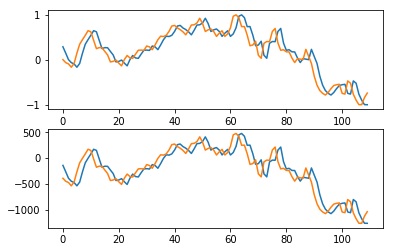

In [82]:
# Scaled supervised dataset
scl_sup_ds = np.zeros((num_segs,num_lookback+num_predict))
sclr = []

def scalewindow(short_seg):
    short_seg = short_seg.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled = scaler.fit_transform(short_seg)
    scaled = scaled.reshape(len(short_seg),)
    return scaled, scaler

for i in np.arange(0,supervised_dataset.shape[0]):
    scl_sup_ds[i,:], scl = scalewindow(supervised_dataset[i,:])  
    sclr.append(scl)
    
plt.subplot(2,1,1)
plt.plot(scl_sup_ds[10,:])
plt.plot(scl_sup_ds[12,:])
plt.subplot(2,1,2)
plt.plot(supervised_dataset[10,:])
plt.plot(supervised_dataset[12,:])

This is the critical step in preparing the data for an LSTM. Each row in the training data matrix will be a "window" with one output. We will slide this window along the training and testing datasets to generate the matrix.

In [83]:
N_train = int(0.8*num_segs)

scaled_train = scl_sup_ds[0:N_train,:]
scaled_test = scl_sup_ds[N_train:,:]

Now we will define the model.

In [89]:
def fit_lstm(train, n_lag, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:-n_lag], train[:, -n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model

model_lstm = fit_lstm(scaled_train, num_predict, 1, 2, 100)
model_lstm.summary()

Epoch 1/1
80000/80000 [==============================] - 346s - loss: 0.1932   
Epoch 1/1
80000/80000 [==============================] - 323s - loss: 0.1751   
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (1, 100)                  80400     
_________________________________________________________________
dropout_1 (Dropout)          (1, 100)                  0         
_________________________________________________________________
dense_9 (Dense)              (1, 10)                   1010      
Total params: 81,410.0
Trainable params: 81,410.0
Non-trainable params: 0.0
_________________________________________________________________


In [90]:
# Make one forecast
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return forecast

def make_forecasts(model, n_batch, test, n_lag):
    forecasts = np.zeros((test.shape[0],n_lag))
    for i in range(test.shape[0]):
        X, y = test[i, 0:-n_lag], test[i, -n_lag:]
        # make forecast
        forecasts[i,:] = forecast_lstm(model, X, n_batch)
    return forecasts

scaled_forecasts = make_forecasts(model_lstm, 1, scaled_test, num_predict)

In [91]:
# inverted forecasts
unscaled_forecasts = np.zeros((scaled_forecasts.shape[0], scaled_forecasts.shape[1]))
unscaled_test = np.zeros((scaled_test.shape[0],scaled_test.shape[1]))

def unscale(X, Y, S):
    for i in range(X.shape[0]):
        seg = X[i,:]
        seg = seg.reshape(-1,1)
        us_X = S[i].inverse_transform(seg)
        us_X1d = us_X.reshape(us_X.shape[0],)
    
        Y[i,:] = us_X1d
    return Y

unscaled_forecasts = unscale(scaled_forecasts, unscaled_forecasts, sclr[N_train:])
unscaled_test_sup = unscale(scaled_test, unscaled_test, sclr[N_train:])

rmse for (LSTM) testing:  [421.79185508 432.45222577 458.34254255 440.92585511 499.27026999
 484.09114759 482.785534   508.20587718 512.35878815 495.26680313]
rmse for (persistence) testing:  [150.93227769 260.98803066 337.23149149 399.01450926 453.82489206
 499.3808881  532.88836884 557.82441337 579.60233954 597.15218801]


<BarContainer object of 10 artists>

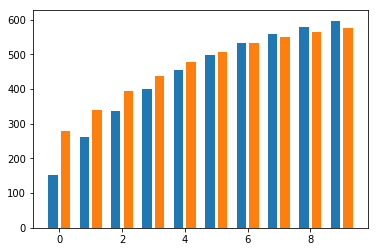

In [92]:
Y_test = unscaled_test_sup[:,-10:]
y_pers_test = np.transpose(np.tile(unscaled_test_sup[:,-num_predict-1], (num_predict,1)))

rmse_lstm_test = np.sqrt(np.mean((unscaled_forecasts-Y_test)**2,axis=0))
print("rmse for (LSTM) testing: ", rmse)

rmse_pers_test = np.sqrt(np.mean((y_pers_test-Y_test)**2,axis=0))
print("rmse for (persistence) testing: ", rmse_pers_test)

plt.figure()
plt.bar(np.arange(0,num_predict)-0.2,rmse_pers_test,0.3)
plt.bar(np.arange(0,num_predict)+0.2,rmse_lstm_test,0.3)

20000


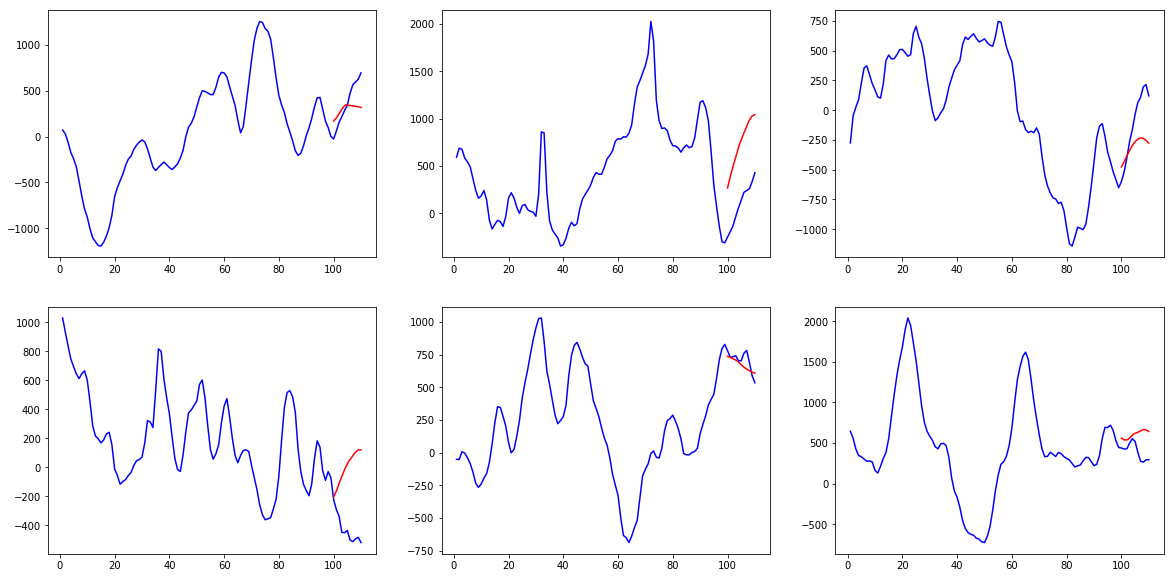

In [94]:
#look at a random sample to see how we did
print(unscaled_test_sup.shape[0])

num_lookback = 100
num_predict = 10
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    sample = np.random.randint(0,unscaled_test_sup.shape[0])
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),unscaled_test_sup[sample,0:chunk_size],color='blue')
    plt.plot(np.linspace(num_lookback,chunk_size,num=num_predict),unscaled_forecasts[sample,:],color='red')